# Motion-Blurred Shape Recognition Playground

## Exploring methods for recognizing and analyzing shapes from motion-blurred images  
*Based on Caglioti and Giusti (2010)*

- biagio.cancelliere@mail.polimi.it
- davide1.franchi@mail.polimi.it
- carlos2.ruiz@mail.polimi.it

## Table of Contents

1. **[Introduction and Motivation](#introduction-and-motivation)**  
2. **[Background and Theoretical Foundations](#background-and-theoretical-foundations)**  
3. **[Dataset and Example Images](#dataset-and-example-images)**  
4. **[Interactive Gradient Exploration: Sobel Filter](#interactive-gradient-exploration-sobel-filter)**  
5. **[Interactive Edge Detection: Canny Filter](#interactive-edge-detection-canny-filter)**  
6. **[Conclusions and Future Work](#conclusions-and-future-work)**  
7. **[References](#references)**  

## 1. Introduction and Motivation

### What information does motion blur provide?

Motion blur occurs when an object moves during the camera's exposure period, creating a visible smear in the captured image. While traditionally considered a limitation in photography, blurred smears can actually encode valuable information about the object's shape and motion characteristics.

The original research by Caglioti and Giusti (2010) leverages these blurred smears to extract detailed geometric and temporal information, such as the object's initial and final contours, motion trajectories, and even intermediate shapes. This notebook aims to explore practical methods inspired by their approach, demonstrating how we can effectively recognize and reconstruct shapes directly from blurred images, thus turning a common photographic artifact into a useful source of visual data.

## 2. Background and Theoretical Foundations

### Motion blur, alpha matting, and geometric interpretation

When an object moves during a camera's exposure time, its projection sweeps across the image plane, resulting in a motion-blurred appearance. This blurred region—called a *smear*—can be interpreted as a semitransparent layer, where the **alpha value** at each pixel corresponds to the fraction of time the object covered that pixel.

The image formation process in this context can be modeled using the **Porter-Duff alpha compositing equation**:

$$
C(p) = \alpha(p) \cdot o(p) + (1 - \alpha(p)) \cdot B(p)
$$

where:

$$
\begin{aligned}
C(p) &\quad \text{is the observed intensity at pixel } p \\\\
o(p) &\quad \text{is the object’s intensity} \\\\
B(p) &\quad \text{is the background intensity} \\\\
\alpha(p) &\in [0, 1] \quad \text{is the proportion of exposure during which the object covers } p
\end{aligned}
$$

The gradient of the alpha matte, denoted as $ \nabla \alpha $
contains crucial structural cues:

- Discontinuities in $ \nabla \alpha $ align with changes in the object’s apparent contour.
- Iso-alpha curves trace the contour at specific instants within the exposure.

This theoretical framework allows one to:

- Identify the object's initial and final contours.
- Estimate envelopes of motion.
- Infer local motion dynamics (e.g., impacts, corners, speed changes).

Understanding these principles forms the foundation for the shape recognition techniques implemented in the rest of this notebook.


## 3. Dataset and Example Images

### Description of the image (`IMG_9264.png`)

To explore motion-blurred shape recognition techniques, we work with a set of sample images captured under controlled motion conditions. The primary image used in this notebook, `IMG_9264.png`, belongs to a sequence in which a ceiling fan moves rapidly across the scene, producing a visible motion blur. It exhibits characteristic streaks and transparency variations caused by object displacement during exposure, making it a suitable candidate for testing shape extraction methods.

Before applying any filters or computational steps, we load and visualize the image to assess its resolution, structure, and blur properties.

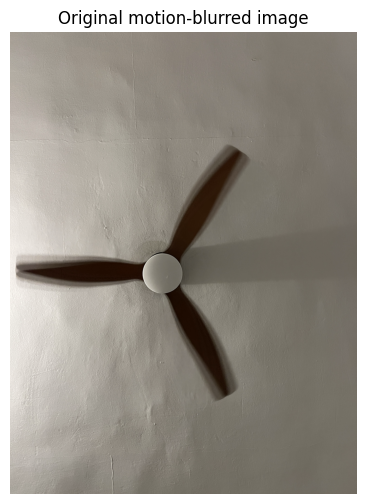

In [10]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../assets/images/IMG_9264.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title("Original motion-blurred image")
plt.axis('off')
plt.show()



### Additional example: `flyingball.png`

The image `flyingball.png` shows a dark spherical object in motion against a flat, uniform background. The object appears blurred along its motion direction, resulting in a soft-edged contour and a semi-transparent gradient toward the motion trail. This type of image is particularly relevant for testing the extraction of iso-alpha curves, envelope contours, and identifying region boundaries without the need for full alpha matte recovery. Its high contrast and simple background make it ideal for gradient-based techniques.

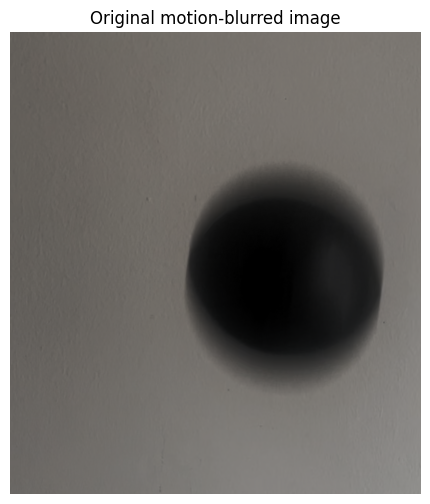

In [11]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../assets/images/flyingball.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title("Original motion-blurred image")
plt.axis('off')
plt.show()



## 4. Interactive Gradient Exploration: Sobel Filter

### Identifying contours with Sobel filters

This section introduces an interactive visualization tool for analyzing how different gradient-based parameters affect contour detection in motion-blurred images.

By applying the Sobel operator to a grayscale version of the input image, we compute the gradient magnitude, which highlights regions with strong intensity changes—typically corresponding to edges and boundaries of the moving object. Before applying the Sobel filter, a Gaussian blur is optionally used to suppress high-frequency noise.

The interface allows the user to experiment with:
- the size and standard deviation of the Gaussian kernel,
- the derivative order in the x and y directions,
- the size of the Sobel kernel,
- normalization and inversion of the result,
- optional thresholding to produce a binary edge map,
- display options such as interpolation method and colormap.

This interactive approach supports visual intuition about the role of each parameter, and helps to identify suitable configurations for emphasizing features such as contour boundaries, envelope shapes, and iso-gradient regions in motion-blurred objects.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown

def show_gradient_interactive(
    gaussian_kernel: int = 5,
    gaussian_sigma: float = 1.0,
    sobel_dx: int = 1,
    sobel_dy: int = 1,
    sobel_ksize: int = 3,
    scale: float = 0.4,
    normalize: bool = True,
    invert: bool = True,
    umbralize: bool = False,
    interpolation: str = 'nearest',
    colormap: str = 'gray',
    dpi: int = 100,
    thresh_val: int = 250
):
    # 1) Leer y escalar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    if scale != 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

    # 2) Gaussian Blur
    img_blur = cv2.GaussianBlur(img, (gaussian_kernel, gaussian_kernel), gaussian_sigma)

    # 3) Sobel en x e y
    gx = cv2.Sobel(img_blur, cv2.CV_64F, sobel_dx, 0, ksize=sobel_ksize)
    gy = cv2.Sobel(img_blur, cv2.CV_64F, 0, sobel_dy, ksize=sobel_ksize)
    mag = np.hypot(gx, gy)

    # 4) Normalizar a [0,255]
    if normalize:
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    mag = mag.astype(np.uint8)

    # 5) Invertir (opcional)
    if invert:
        mag = cv2.bitwise_not(mag)

    if umbralize:
        # 6) Umbralizar usando el valor ajustable
        _, mag = cv2.threshold(mag, thresh_val, 255, cv2.THRESH_BINARY)

    # 7) Mostrar resultado umbralizado
    plt.figure(figsize=(img.shape[1]/dpi, img.shape[0]/dpi), dpi=dpi)
    plt.imshow(mag, cmap=colormap, vmin=0, vmax=255, interpolation=interpolation)
    plt.title(
        f"Gk={gaussian_kernel} σ={gaussian_sigma:.1f} | "
        f"Sx={sobel_dx} Sy={sobel_dy} k={sobel_ksize} | "
        f"Threshold={thresh_val} | scale={scale} dpi={dpi}"
    )
    plt.axis('off')
    plt.show()

In [13]:
img_path = "../assets/images/IMG_9264.png"

interact(
    show_gradient_interactive,
    gaussian_kernel=IntSlider(13, min=1, max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(1.0, min=0.0, max=10.0, step=0.5, description='σ Gauss'),
    sobel_dx=IntSlider(1, min=0, max=2, step=1, description='Sobel dx'),
    sobel_dy=IntSlider(1, min=0, max=2, step=1, description='Sobel dy'),
    sobel_ksize=IntSlider(25, min=1, max=31, step=2, description='Sobel k'),
    scale=FloatSlider(0.4, min=0.1, max=1.0, step=0.1, description='Scale'),
    normalize=Checkbox(True, description='Normalize'),
    invert=Checkbox(True, description='Invert'),
    umbralize=Checkbox(True, description='Umbralize'),
    interpolation=Dropdown(
        options=['nearest', 'bilinear', 'bicubic', 'antialiased'],
        value='nearest',
        description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray', 'viridis', 'hot', 'magma', 'inferno'],
        value='gray',
        description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI'),
    thresh_val=IntSlider(239, min=150, max=255, step=1, description='Threshold')
)


interactive(children=(IntSlider(value=13, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=1.0…

<function __main__.show_gradient_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, sobel_dx: int = 1, sobel_dy: int = 1, sobel_ksize: int = 3, scale: float = 0.4, normalize: bool = True, invert: bool = True, umbralize: bool = False, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, thresh_val: int = 250)>

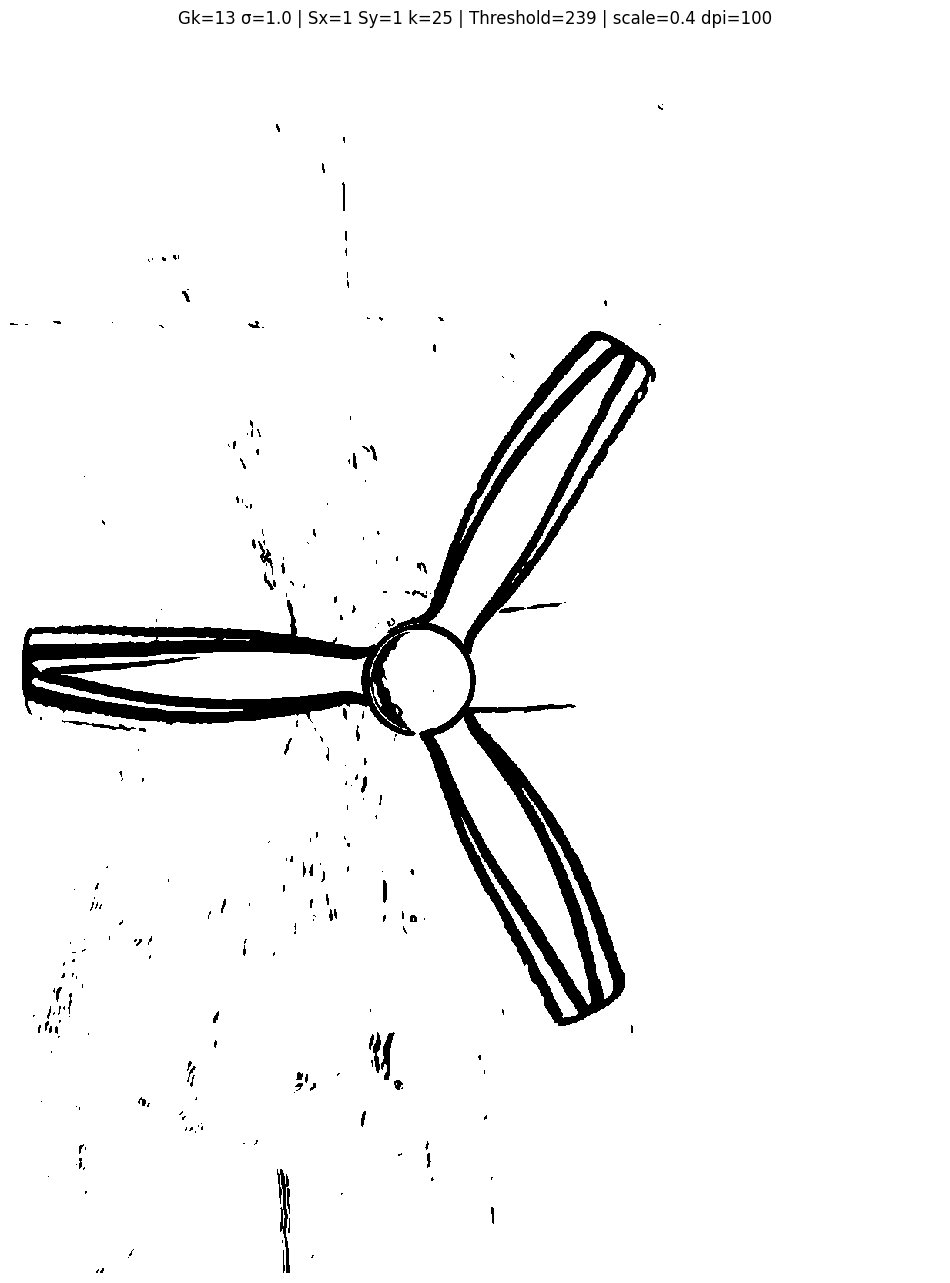

In [14]:
img_path = "../assets/images/IMG_9264.png"

interact(
    show_gradient_interactive,
    gaussian_kernel=IntSlider(13, min=1, max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(1.0, min=0.0, max=10.0, step=0.5, description='σ Gauss'),
    sobel_dx=IntSlider(1, min=0, max=2, step=1, description='Sobel dx'),
    sobel_dy=IntSlider(1, min=0, max=2, step=1, description='Sobel dy'),
    sobel_ksize=IntSlider(25, min=1, max=31, step=2, description='Sobel k'),
    scale=FloatSlider(0.4, min=0.1, max=1.0, step=0.1, description='Scale'),
    normalize=Checkbox(True, description='Normalize'),
    invert=Checkbox(True, description='Invert'),
    umbralize=Checkbox(False, description='Umbralize'),
    interpolation=Dropdown(
        options=['nearest', 'bilinear', 'bicubic', 'antialiased'],
        value='nearest',
        description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray', 'viridis', 'hot', 'magma', 'inferno'],
        value='gray',
        description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI'),
    thresh_val=IntSlider(239, min=150, max=255, step=1, description='Threshold')
)

interactive(children=(IntSlider(value=13, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=1.0…

<function __main__.show_gradient_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, sobel_dx: int = 1, sobel_dy: int = 1, sobel_ksize: int = 3, scale: float = 0.4, normalize: bool = True, invert: bool = True, umbralize: bool = False, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, thresh_val: int = 250)>

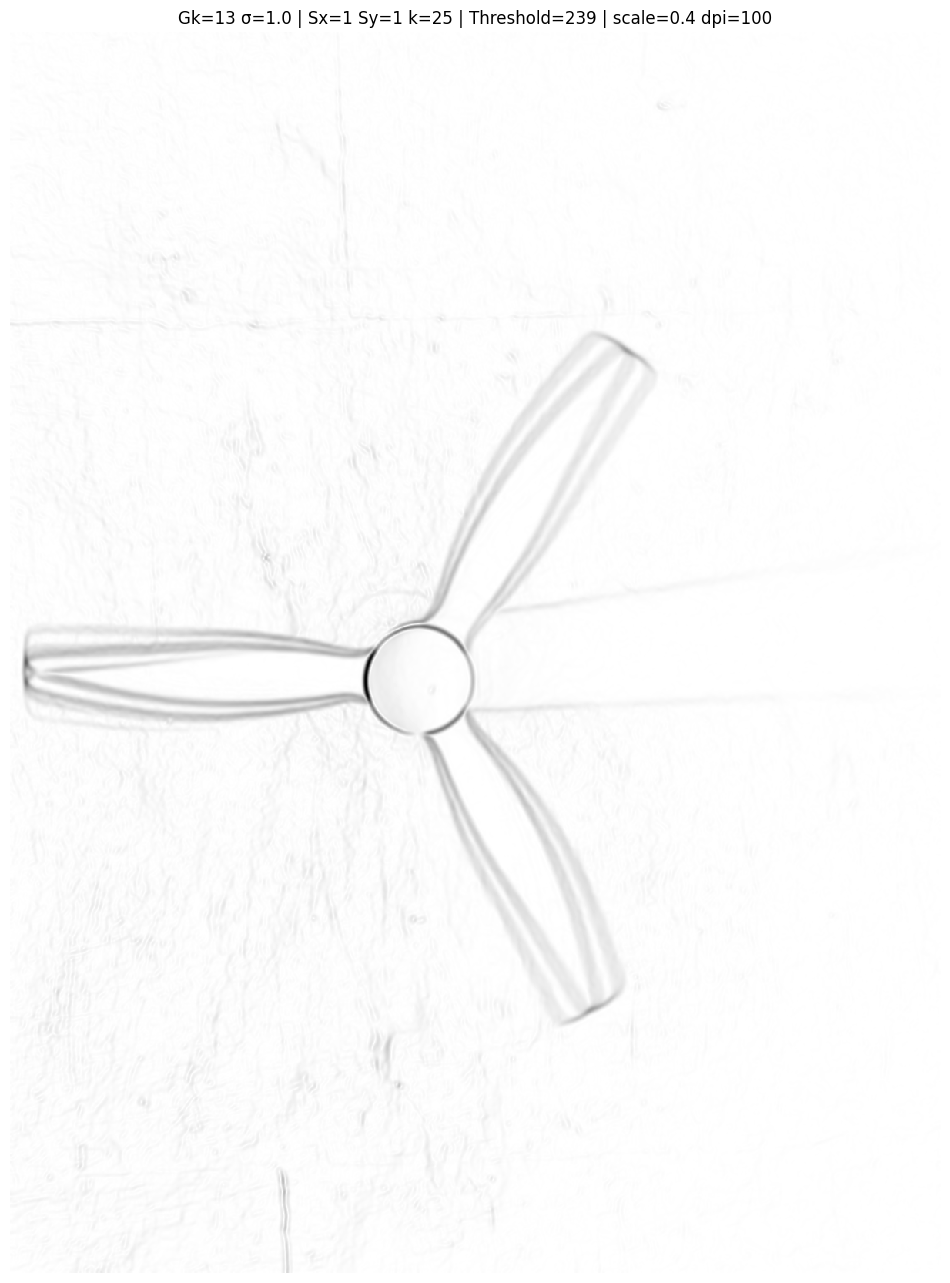

In [15]:
img_path = "../assets/images/flyingball.png"

interact(
    show_gradient_interactive,
    gaussian_kernel=IntSlider(1, min=1, max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(1.0, min=0.0, max=10.0, step=0.5, description='σ Gauss'),
    sobel_dx=IntSlider(1, min=0, max=2, step=1, description='Sobel dx'),
    sobel_dy=IntSlider(1, min=0, max=2, step=1, description='Sobel dy'),
    sobel_ksize=IntSlider(9, min=1, max=31, step=2, description='Sobel k'),
    scale=FloatSlider(0.6, min=0.1, max=1.0, step=0.1, description='Scale'),
    normalize=Checkbox(True, description='Normalize'),
    invert=Checkbox(True, description='Invert'),
    umbralize=Checkbox(False, description='Umbralize'),
    interpolation=Dropdown(
        options=['nearest', 'bilinear', 'bicubic', 'antialiased'],
        value='nearest',
        description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray', 'viridis', 'hot', 'magma', 'inferno'],
        value='gray',
        description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI'),
    thresh_val=IntSlider(239, min=150, max=255, step=1, description='Threshold')
)

interactive(children=(IntSlider(value=1, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=1.0,…

<function __main__.show_gradient_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, sobel_dx: int = 1, sobel_dy: int = 1, sobel_ksize: int = 3, scale: float = 0.4, normalize: bool = True, invert: bool = True, umbralize: bool = False, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, thresh_val: int = 250)>

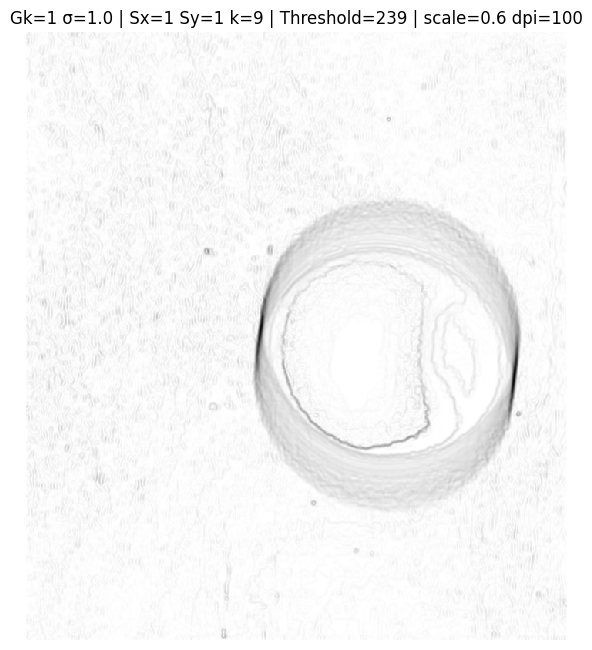

## 5. Interactive Edge Detection: Canny Filter

### Edge detection comparisons

In this section, we explore the application of the **Canny edge detector** as a tool for contour extraction in motion-blurred images.

Canny filtering is particularly effective at highlighting well-defined edges while suppressing noise, making it a strong candidate for identifying the outer boundaries of fast-moving objects captured with long exposure. By adjusting its parameters interactively—such as the low and high thresholds, Gaussian smoothing, and aperture size—we can observe how different configurations affect the visibility and continuity of the resulting contours.

Compared to gradient magnitude visualizations (as seen in the Sobel-based analysis in Section 4), the Canny filter provides a binary edge map that is often more selective, but may fail to capture subtle structures present in smoother transitions of blur. This makes it especially valuable for detecting:
- the initial and final apparent contours of a moving object,
- sharp structural transitions within the blur smear,
- high-contrast envelope boundaries.

Through interactive tuning, users can assess the filter's effectiveness and develop an intuition for its strengths and limitations in shape recovery tasks.

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown

def show_canny_interactive(
    gaussian_kernel: int = 5,
    gaussian_sigma: float = 1.0,
    low_thresh: int = 50,
    high_thresh: int = 150,
    aperture_size: int = 3,
    L2gradient: bool = False,
    scale: float = 1.0,
    interpolation: str = 'nearest',
    colormap: str = 'gray',
    dpi: int = 100,
    invert: bool = True
):
    # 1) Leer y escalar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    if scale != 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        h, w = img.shape

    # 2) Suavizado Gaussiano (kernel impar)
    gk = gaussian_kernel | 1
    blur = cv2.GaussianBlur(img, (gk, gk), gaussian_sigma)

    # 3) Canny
    # aperture_size debe ser 3,5,7; forzamos impar y >=3
    ap = max(3, aperture_size | 1)
    canny = cv2.Canny(blur, low_thresh, high_thresh,
                      apertureSize=ap,
                      L2gradient=L2gradient)
    
    # 5) Invertir (opcional)
    if invert:
        canny = cv2.bitwise_not(canny)

    # 4) Mostrar sin márgenes
    fig = plt.figure(figsize=(w/dpi, h/dpi), dpi=dpi)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax = fig.add_subplot(111)
    ax.imshow(canny, cmap=colormap,
              vmin=0, vmax=255,
              interpolation=interpolation)
    ax.axis('off')
    ax.set_title(f"Gauss k={gk} σ={gaussian_sigma:.1f} | "
                 f"Canny low={low_thresh} high={high_thresh} | "
                 f"ap={ap} L2={L2gradient}")
    plt.show()

In [ ]:
img_path = "../assets/images/IMG_9264.png"

interact(
    show_canny_interactive,
    gaussian_kernel=IntSlider(27,   min=1,  max=31, step=2, description='Gauss k'),
    gaussian_sigma=FloatSlider(2.0, min=0.0,max=10.0,step=0.5,description='σ Gauss'),
    low_thresh=IntSlider(255,  min=0,  max=255, step=1, description='Low Th'),
    high_thresh=IntSlider(255, min=0,  max=255, step=1, description='High Th'),
    aperture_size=IntSlider(5, min=3,  max=7,   step=1, description='Aperture'),
    L2gradient=Checkbox(True, description='L2 grad'),
    scale=FloatSlider(0.3, min=0.1, max=1.0, step=0.1, description='Scale'),
    interpolation=Dropdown(
        options=['nearest','bilinear','bicubic','antialiased'],
        value='nearest', description='Interp.'
    ),
    colormap=Dropdown(
        options=['gray','viridis','hot','magma','inferno'],
        value='gray', description='Colormap'
    ),
    dpi=IntSlider(100, min=50, max=300, step=50, description='DPI')
)


interactive(children=(IntSlider(value=27, description='Gauss k', max=31, min=1, step=2), FloatSlider(value=2.0…

<function __main__.show_canny_interactive(gaussian_kernel: int = 5, gaussian_sigma: float = 1.0, low_thresh: int = 50, high_thresh: int = 150, aperture_size: int = 3, L2gradient: bool = False, scale: float = 1.0, interpolation: str = 'nearest', colormap: str = 'gray', dpi: int = 100, invert: bool = True)>

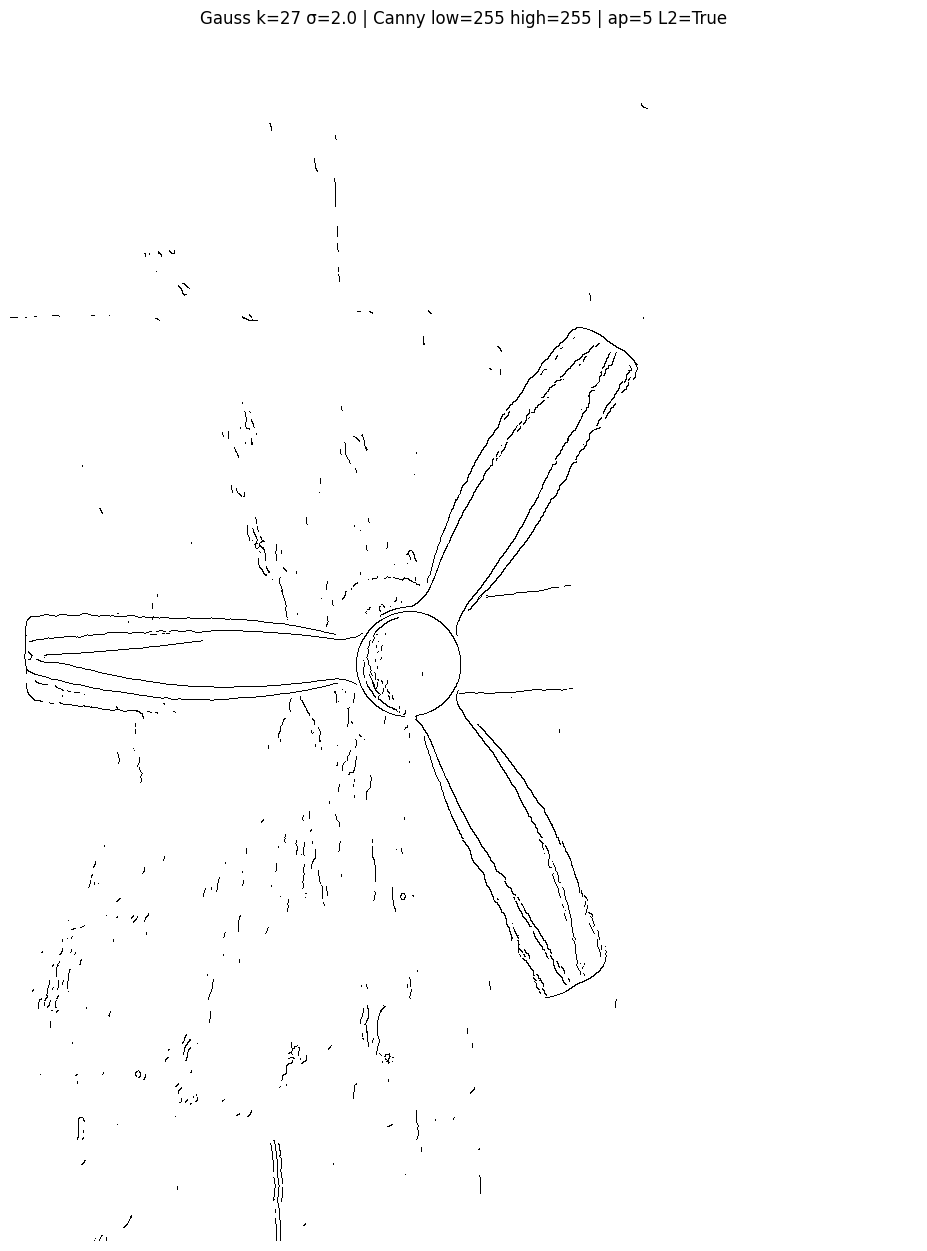

## 6. Conclusions

In this notebook, we explored the problem of shape recognition in motion-blurred images by analyzing gradient-based features and applying classical edge detection techniques. Building on the theoretical framework presented by Caglioti and Giusti (2010), we demonstrated that a significant amount of spatial and motion-related information can be extracted from a single blurred image—even without explicitly computing the alpha matte.

Through interactive experiments with Sobel and Canny filters, we showed how parameter tuning influences the visibility and continuity of object contours. These visualizations allowed us to:
- Approximate initial and final contours of the moving object.
- Identify envelope boundaries and gradient discontinuities.

While the absence of a true alpha matte limits the interpretability of finer motion structure, the use of gradient magnitude and edge detection provides a lightweight and practical method for extracting meaningful geometric features from motion-blurred imagery.